In [2]:
import time
import os
import random
import math

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

%matplotlib inline

In [3]:
assert os.environ['COLAB_GPU'], 'Make sure to select GPU from Edit > Notebook settings > Hardware accelerator'
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!rm -f data
!ln -s '/content/drive/My Drive/proj2_data' data

In [5]:
def collate_fn1(batch):
    return tuple(zip(*batch))

def imshow(img, gt_box, turb_type,pred_box=None):
    plt.imshow(img)
    
    def draw_box(box, turb_type):
        x, y, w, h = box
        if x == 0:
            x = 1
        if y == 0:
            y = 1
        if turb_type=='turbulence':
          color='red'
        else:
          color='green'
        plt.gca().add_patch(
            plt.Rectangle((x, y), w-x, h-y,
                          fill=False, edgecolor=color, linewidth=2, alpha=0.5)
        )
    for i in range(len(box)):
      draw_box(box[i],turb_type[i])
    if pred_box is not None:
        draw_box(pred_box, 'blue')
    plt.plot()

In [6]:
class MyDataset(Dataset):
    def __init__(self, datatype='train', transform=None):
        with open('data/bbox_'+datatype+'.csv') as f:
            id_to_box = dict()
            id_to_path = dict()
            id_to_turb= dict()
            last_name='none'
            idx=-1
            for line in f.read().splitlines():
                filename, wid, hei, turb, *box = line.split(',') # get all variable
                if turb =='severe turbulence':
                  turb_no=2
                else:
                  turb_no=1
                if filename == 'filename': # skip the title
                  continue

                if filename==last_name:
                  id_to_box[idx].append(list(map(float, box)))
                  id_to_turb[idx].append(turb_no)
                  
                else:
                  idx=idx+1
                  id_to_path[idx]=filename
                  id_to_box[idx]=[list(map(float, box))]
                  id_to_turb[idx]=[turb_no]
                  last_name=filename

            self.imgs = [(os.path.join('data/'+datatype, id_to_path[i]), id_to_box[i],id_to_turb[i])
                     for i in range(len(id_to_path))]

            #transform data
            self.target_transform = transforms.Compose([
                transforms.Resize((840, 840)),
                transforms.ToTensor()
            ])
            self.transform = transforms.Compose([
                self.target_transform,
                #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
            if transform is not None:
                self.transform = transforms.Compose([
                    transform,
                    self.transform
                ])
                self.target_transform = transforms.Compose([
                    transform,
                    self.target_transform
                ])

    def __getitem__(self, index):
      path, box, turb = self.imgs[index]
      im = (np.load(path))/292*255
      im=np.transpose(im,(1, 2, 0))
      im=np.uint8(im)
      boxes = np.array(box, dtype='float32')
      seed = np.random.randint(2147483647)
      random.seed(seed)
      torch.manual_seed(seed)
      PIL = transforms.ToPILImage()(im).convert('RGB')#if you want to output 4 dimension data, change to .convert('RGBA'). While you will not able to do transforms.Normalize()
      im = self.transform(PIL)*255


      #return im,target
      return im, boxes, turb

    def __len__(self):
        return len(self.imgs)

In [7]:
#dataloader
train=MyDataset(datatype='train', transform=None)
test=MyDataset(datatype='test', transform=None)
val=MyDataset(datatype='val', transform=None)
datasets={'train':train,'test':test,'val':val}
dataloaders = {k: torch.utils.data.DataLoader(
                v, batch_size=32, shuffle=(k=='train'),
                num_workers=2,collate_fn=collate_fn1,pin_memory=True) for k, v in datasets.items()}

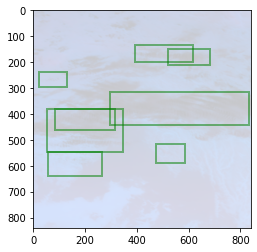

In [8]:
dataset=MyDataset(datatype='train',transform=None)
im, box, turb = dataset[0]

inp = im.numpy().transpose((1, 2, 0))/255
#mean = np.array([0.485, 0.456, 0.406])
#std = np.array([0.229, 0.224, 0.225])
#inp = std * inp + mean
imshow(inp, box,turb)

In [ ]:
idx=0
for i in enumerate(dataloaders['train']):
  print(i)
  idx=idx+1
  if idx==3:break

In [ ]:
im, box, turb = dataset[1]
inp = im.numpy().transpose((1, 2, 0))/255
imshow(inp, box,turb) 
print(box) # the ground truth


for j in range(len(dataset)):
  im, box, turb = dataset[j]
  inp = im.numpy().transpose((1, 2, 0))/255
  for i in range(len(box)):
    #get the Ground truth
    print(box[i])
    GXmin=box[i][0]
    GYmin=box[i][1]
    GXmax=box[i][2]
    GYmax=box[i][3]
    #print(GYmax)
    #calculate area
    GArea=(GXmax-GXmin)*(GYmax-GYmin)
    #print(GArea)
    

    #get the RoI
    #assuming the data format is the same as box
    RoI_Xmin=RoI[i][0]
    RoI_Ymin=RoI[i][1]
    RoI_Xmax=RoI[i][2]
    RoI_Ymax=RoI[i][3]
    RoIArea=(RoI_Xmax-RoI_Xmin)*(RoI_Ymax-RoI_Ymin)
    
    
    #calculate the overlapping rate
    #overlap
    #torchvision.ops.box_iou()
    intersectXmin=max(GXmin,RoI_Xmin)
    intersectXmax=min(GXmax,RoI_Xmax)
    intersectYmin=max(GYmin,RoI_Ymin)
    intersectYmax=min(GXmax,RoI_Xmax)
    intersectArea=(intersectXmax-intersectXmin)*(intersectYmax-intersectYmin)
    union=GArea+RoIArea-intersectArea
    iou=intersectArea/union



    if iou >= 0.5:
      #set the label positive
      #selesct 25%

    elif iou>=0.1 and iou <0.5:
      #set the label negative
      #select the max one


(tensor([[[209., 203., 203.,  ..., 209., 208., 208.],
         [209., 203., 203.,  ..., 209., 209., 209.],
         [209., 203., 203.,  ..., 209., 209., 209.],
         ...,
         [215., 212., 212.,  ..., 215., 215., 215.],
         [215., 212., 212.,  ..., 215., 215., 215.],
         [215., 212., 212.,  ..., 215., 215., 215.]],

        [[212., 209., 209.,  ..., 211., 211., 211.],
         [212., 209., 209.,  ..., 212., 212., 212.],
         [212., 210., 210.,  ..., 212., 212., 212.],
         ...,
         [218., 225., 225.,  ..., 218., 218., 218.],
         [218., 225., 225.,  ..., 218., 218., 218.],
         [218., 224., 223.,  ..., 218., 218., 218.]],

        [[232., 228., 228.,  ..., 231., 232., 232.],
         [232., 228., 228.,  ..., 232., 232., 232.],
         [232., 229., 229.,  ..., 232., 232., 232.],
         ...,
         [235., 250., 249.,  ..., 234., 234., 235.],
         [234., 250., 250.,  ..., 234., 234., 234.],
         [234., 249., 246.,  ..., 234., 234., 234.]]

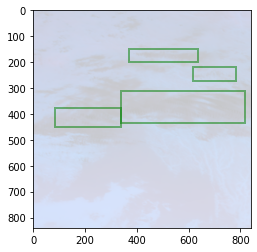

In [34]:
im, box, turb = dataset[1]
inp = im.numpy().transpose((1, 2, 0))/255
imshow(inp, box,turb) 
print(box) # the ground truth


for j in range(dataset):
  im, box, turb = dataset[j]
  inp = im.numpy().transpose((1, 2, 0))/255
  box_tensor = torch.Tensor(list(box))
  #testing
  #RoI_tensor = torch.Tensor(list(box-1))

  #assuming the data format of RoI is the same as box
  RoI_tensor = torch.Tensor(list(RoI))
  #print (box_tensor)
  #print (RoI_tensor)
  iou=torchvision.ops.box_iou(box_tensor,RoI_tensor)
  print (iou)

  for i in range(len(iou)):
    for j in range(len(iou[i])):
      if iou[i][j]>0:
        #print(iou[i][j])
        if iou[i][j] >= 0.5:
          print("set the label positive")
          #selesct 25%

        elif iou[i][j]>=0.1 and iou[i][j] <0.5:
          print("set the label negative")
          #select the max one
      else:
        continue

Function

In [ ]:
def mini_batch_sampling(img_list):
  #assume the input is the list of 2 image, which is of tensor type
  #each tensor consists of RoIs, which are [label, x1, y1, x2, y2, iou] 
  #--> image is tensor([label, x1, y1, x2, y2, iou], [label, x1, x2, y1, y2, iou]...)
  
  #test
  #in here i assume two picture has 20 RoI
  input = []
  for i in range(2):
    dummy = torch.zeros([20,6], dtype=torch.float32)
    for j in range(20):
      x1 = j*84
      y1 = j*84
      x2 = (j+1)*84
      y2 = (j+1)*84
      iou = ((j)/20)+0.5
      #assume -1 is negative, 1 is positive
      if j%3 ==0:
        dummy[j][0] = 1
      else:
        dummy[j][0] = -1
      dummy[j][1] = x1
      dummy[j][2] = y1
      dummy[j][3] = x2
      dummy[j][4] = x2
      dummy[j][5] = iou
    input.append(dummy)
#  print (input)


  list_roi=[]
  #rint(len(input))
  for i in range (len(input)):
    #calculate the number for the needed RoI list
    pos_total=0
    pos=[]
    neg_total=0
    neg=[]

    for k in range(len(input[i])):
    if input[i][k][0] == 1:
      pos_total+=1
      pos.append(input[i][k])
    elif input[i][k][0] == -1:
      neg_total+=1
      neg.append(input[i][k])

#    print(pos_total)
#    print(pos)
#    print(neg_total)
#    print(neg)

    #for the positive, calculate the 25% --> n
    n=round(pos_total/4)
    #print(n)

    #for the negative, choose the max overlapping iou --> m
    m=1

    #roi=torch.zeros([m+n, 4], dtype=torch.float32)
    dummy_roi=torch.zeros([m+n, 4], dtype=torch.float32)
    for j in range(n): #for the positive 
      x1=pos[j][1]
      y1=pos[j][2]
      x2=pos[j][3]
      y2=pos[j][4]
      dummy_roi[j][0] = x1
      dummy_roi[j][1] = y1
      dummy_roi[j][2] = x2
      dummy_roi[j][3] = x2

    #for the negative part
    #find the max iou
    id_max=0
    max=-1
    for j in range (neg_total):
      if neg[j][5]>max:
        max=neg[j][5]
        id_max=j
    #print(id_max)

    x1=neg[id_max][1]
    y1=neg[id_max][2]
    x2=neg[id_max][3]
    y2=neg[id_max][4]
    dummy_roi[n][0] = x1
    dummy_roi[n][1] = y1
    dummy_roi[n][2] = x2
    dummy_roi[n][3] = x2
    list_roi.append(dummy_roi)

    

  # print(list_roi)

  return list_roi

Test

In [118]:
input = []
for i in range(2):
  dummy = torch.zeros([66,6], dtype=torch.float32)
  for j in range(66):
    x1 = j*84
    y1 = j*84
    x2 = (j+1)*84
    y2 = (j+1)*84
    iou = ((j)/20)+0.5
    #assume -1 is negative, 1 is positive
    if j%3 ==0:
      dummy[j][0] = 1
    else:
      dummy[j][0] = -1
    dummy[j][1] = x1
    dummy[j][2] = y1
    dummy[j][3] = x2
    dummy[j][4] = x2
    dummy[j][5] = iou
  input.append(dummy)
print (input)


list_roi=[]
#rint(len(input))
for i in range (len(input)):
  #calculate the number for the needed RoI list
  pos_total=0
  pos=[]
  neg_total=0
  neg=[]

  for k in range(len(input[i])):
   if input[i][k][0] == 1:
     pos_total+=1
     pos.append(input[i][k])
   elif input[i][k][0] == -1:
     neg_total+=1
     neg.append(input[i][k])

  print(pos_total)
  print(pos)
  print(neg_total)
  print(neg)

  #for the positive, calculate the 25% --> n
  n=round(pos_total/4)
  #print(n)

  #for the negative, choose the max overlapping iou --> m
  m=1

  #roi=torch.zeros([m+n, 4], dtype=torch.float32)
  dummy_roi=torch.zeros([m+n, 4], dtype=torch.float32)
  for j in range(n): #for the positive 
    x1=pos[j][1]
    y1=pos[j][2]
    x2=pos[j][3]
    y2=pos[j][4]
    dummy_roi[j][0] = x1
    dummy_roi[j][1] = y1
    dummy_roi[j][2] = x2
    dummy_roi[j][3] = x2

  #for the negative part
  #find the max iou
  id_max=0
  max=-1
  for j in range (neg_total):
    if neg[j][5]>max:
      max=neg[j][5]
      id_max=j
  #print(id_max)

  x1=neg[id_max][1]
  y1=neg[id_max][2]
  x2=neg[id_max][3]
  y2=neg[id_max][4]
  dummy_roi[n][0] = x1
  dummy_roi[n][1] = y1
  dummy_roi[n][2] = x2
  dummy_roi[n][3] = x2
  list_roi.append(dummy_roi)

  

print(list_roi)

[tensor([[ 1.0000e+00,  0.0000e+00,  0.0000e+00,  8.4000e+01,  8.4000e+01,
          5.0000e-01],
        [-1.0000e+00,  8.4000e+01,  8.4000e+01,  1.6800e+02,  1.6800e+02,
          5.5000e-01],
        [-1.0000e+00,  1.6800e+02,  1.6800e+02,  2.5200e+02,  2.5200e+02,
          6.0000e-01],
        [ 1.0000e+00,  2.5200e+02,  2.5200e+02,  3.3600e+02,  3.3600e+02,
          6.5000e-01],
        [-1.0000e+00,  3.3600e+02,  3.3600e+02,  4.2000e+02,  4.2000e+02,
          7.0000e-01],
        [-1.0000e+00,  4.2000e+02,  4.2000e+02,  5.0400e+02,  5.0400e+02,
          7.5000e-01],
        [ 1.0000e+00,  5.0400e+02,  5.0400e+02,  5.8800e+02,  5.8800e+02,
          8.0000e-01],
        [-1.0000e+00,  5.8800e+02,  5.8800e+02,  6.7200e+02,  6.7200e+02,
          8.5000e-01],
        [-1.0000e+00,  6.7200e+02,  6.7200e+02,  7.5600e+02,  7.5600e+02,
          9.0000e-01],
        [ 1.0000e+00,  7.5600e+02,  7.5600e+02,  8.4000e+02,  8.4000e+02,
          9.5000e-01],
        [-1.0000e+00,  8.4000

In [119]:
n=round(22/4)
print(n)

6


In [27]:
def extractImgbyRoI(img, RoI):
  return img[:, RoI[0]:RoI[2], RoI[1]:RoI[3]]

In [ ]:
def myImgShow(img):
  plt.imshow(inp)

In [ ]:
def constructNeighbourGrid():
  size = 10
  neighbourGrid = []
  
  
  for i in range(size):
    for j in range(size):
      background = np.zeros((10, 10))
      background[i][j] = 1
      # Dilation
      if i-1 >= 0: background[i-1][j] = 1
      if i+1 < size: background[i+1][j] = 1
      if j-1 >= 0: background[i][j-1] = 1
      if j+1 < size: background[i][j+1] = 1

      background = background.flatten()
      neighbourGrid.append(background == 1)

  return np.array(neighbourGrid)

In [ ]:
def initRoIs(img, size):
  _, h, w = img.shape
  sub_h, sub_w = math.floor(h/size), math.floor(w/size)
  RoIs = np.array([[[j*sub_w, i*sub_h, (j+1)*sub_w-1, (i+1)*sub_h-1] for j in range(size)] for i in range(size)])
  RoIs = RoIs.reshape(size*size, 4)
  return RoIs

In [ ]:
def getHist(img):
  D, _, _ - img.shape
  for channel_idx in range(D):
    h, _ = np.histogram(img[channel_idx, :, :], bins=25)
    histogram = histogram + list(h)
  histogram = np.array(histogram/np.linalg.norm(histogram, 1))
  return histogram

In [ ]:
def sim(region1, region2):
  histogram1 = getHist(region1)
  histogram2 = getHist(region2)

  sim = np.vstack((histogram1, histogram2))
  sim = np.amin(sim, 0)
  sim = sim.sum()

  return sim

In [ ]:
dataset=MyDataset(datatype='train',transform=None)
im, box, turb = dataset[0]
RoIs = initRoIs(im, 10)
print(RoIs.shape)
neighbourGrid = constructNeighbourGrid()

(100, 4)


torch.Size([3, 839, 83])


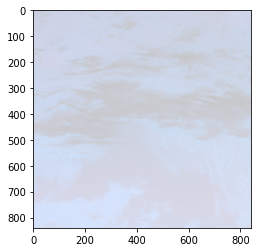

In [ ]:
sub_img = extractImgbyRoI(im, region)
print(sub_img.shape)
myImgShow(sub_img)

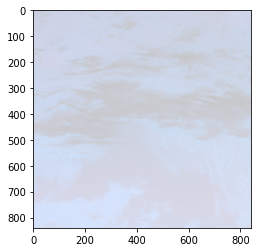

In [ ]:
dataset=MyDataset(datatype='train',transform=None)
im, box, turb = dataset[0]

i = im.numpy().transpose((1, 2, 0))/255
plt.imshow(i)
